In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from integration.integrate import *

In [2]:
@jit(nopython=True)
def f(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x)

@jit(nopython=True)
def g(x,t):
    return np.zeros((2,2))

@jit(nopython=True)
def f_cubic(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x**3)

In [3]:
ti,tf,dt = 0,25,0.005
times = np.arange(ti,tf,dt)
x0=np.array([2.,0.])
xx1 = integrate(f,g,x0,times,dt,mode="RK4")
xx1_cubic = integrate(f_cubic,g,x0,times,dt,mode="RK4")


/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/learn_torch/integration/steps.py:33: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  k1 = dt*f(x1,t) + np.sqrt(q1)*g(x1,t).dot(dw)


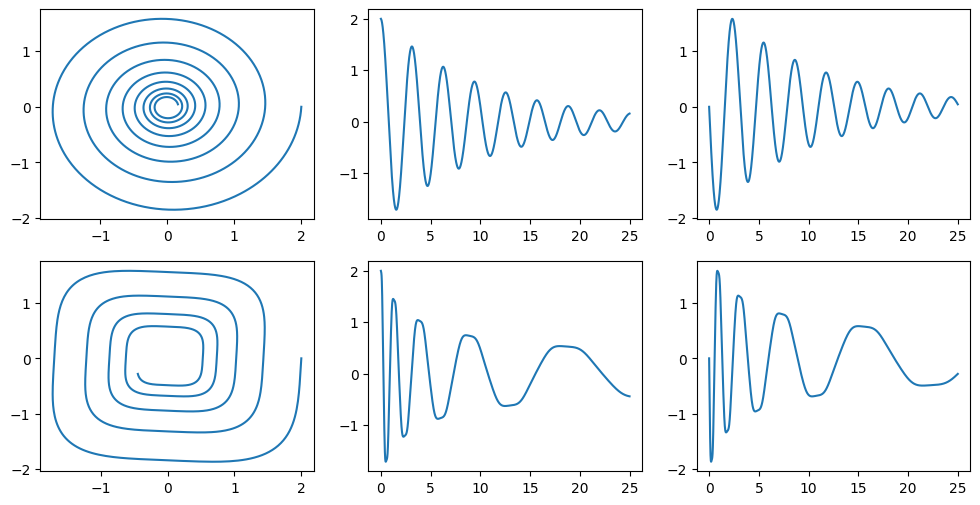

In [7]:
plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax = plt.subplot(233)
ax.plot(times, xx1[1,:])

ax = plt.subplot(234)
ax.plot(xx1_cubic[0,:], xx1_cubic[1,:])
ax = plt.subplot(235)
ax.plot(times, xx1_cubic[0,:])
ax = plt.subplot(236)
ax.plot(times, xx1_cubic[1,:])

In [10]:
name = "data/lineal_oscillator/"
os.makedirs(name,exist_ok=True)
np.save(name+"{}_{}_{}".format(ti,tf,dt), xx1)

name = "data/cubic_oscillator/"
os.makedirs(name,exist_ok=True)
np.save(name+"{}_{}_{}".format(ti,tf,dt), xx1_cubic)

In [126]:
XSindy_dot = Th_value.dot(Cof)
print(XSindy_dot.shape)
print(Th_value.shape)
print(Cof.shape)

(5000, 2)
(5000, 4)
(4, 2)


In [320]:
from sklearn import linear_model

X = xx1.T
X_dot = np.array([f(xx,t) for xx,t in zip(xx1.T, times)])


lin_mod = linear_model.Lasso(alpha=0.00001,tol=1e-14)
lasso_model = lin_mod.fit(Th_value, X_dot)

p = 4
Cof = np.random.randn(p,2)

#Th = {'1':X,'3': X**3}
#Th_value = np.concatenate(list(Th.values()), axis=-1)
f0 = lambda k: k
f1 = lambda k: k**3
Th_value = np.concatenate([f0(X), f1(X)], axis=-1)

In [321]:
#help(lasso_model.score) Computes R**2
print("R^: ", lasso_model.score(Th_value, X_dot) ) #

# MSE: 
print("MSE: " , np.mean((Th_value.dot(lasso_model.coef_.T) - X_dot)**2))

R^:  0.9999999996057334
MSE:  6.275288252432511e-10


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 87201.08it/s]


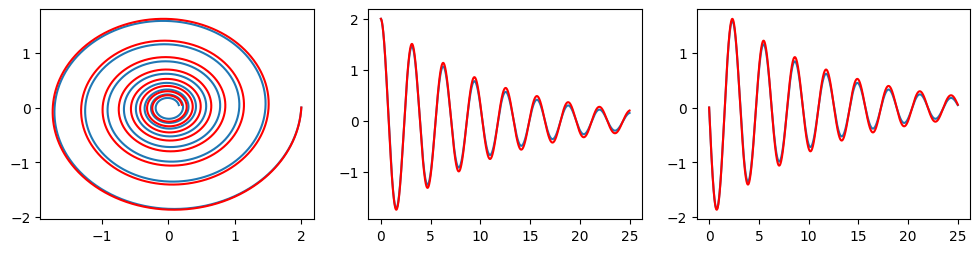

In [322]:
coeffs = lasso_model.coef_.T
constrain = np.abs(coeffs)<1e-2
coeffs[constrain] = 0.


x_hat = np.array([2,0.])
x_hats = [x_hat]
for x in tqdm(X[:-1]):
    x_hat = x_hat + dt*np.concatenate([f0(x_hat), f1(x_hat)]).dot(coeffs)
    x_hats.append(x_hat)
x_hats = np.array(x_hats)

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(x_hats[:,0], x_hats[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, x_hats[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, x_hats[:,1], color="red")


In [323]:
coeffs

array([[-0.09995577, -1.9999583 ],
       [ 1.9999561 , -0.09995664],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [326]:
from sklearn import linear_model

X = xx1_cubic.T
X_dot = np.array([f_cubic(xx,t) for xx,t in zip(xx1_cubic.T, times)])


lin_mod = linear_model.Lasso(alpha=0.00001,tol=1e-3,precompute=True)#alpha=0.05, tol=1e-10)
lasso_model = lin_mod.fit(Th_value, X_dot)

p = 4
Cof = np.random.randn(p,2)

#Th = {'1':X,'3': X**3}
#Th_value = np.concatenate(list(Th.values()), axis=-1)
f0 = lambda k: k
f1 = lambda k: k**3
Th_value = np.concatenate([f0(X), f1(X)], axis=-1)

In [327]:
#help(lasso_model.score) Computes R**2
print("R^: ", lasso_model.score(Th_value, X_dot) ) #

# MSE: 
print("MSE: " , np.mean((Th_value.dot(lasso_model.coef_.T) - X_dot)**2))

R^:  0.9999996866295755
MSE:  1.0128031980060851e-06


In [328]:
coeffs

array([[-0.09995577, -1.9999583 ],
       [ 1.9999561 , -0.09995664],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [294]:
coeffs = lasso_model.coef_.T
constrain = np.abs(coeffs)<1e-2
coeffs[constrain] = 0.


In [295]:
coeffs

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.10003268, -1.998725  ],
       [ 1.99876109, -0.10042759]])

In [311]:
Th_value.dot(coeffs)

array([[ -0.80026142, -15.98980001],
       [ -0.7964966 , -15.89426075],
       [ -0.79877087, -15.79894681],
       ...,
       [ -0.03627645,   0.1760602 ],
       [ -0.03584595,   0.17625157],
       [ -0.03541773,   0.17644069]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 102115.75it/s]


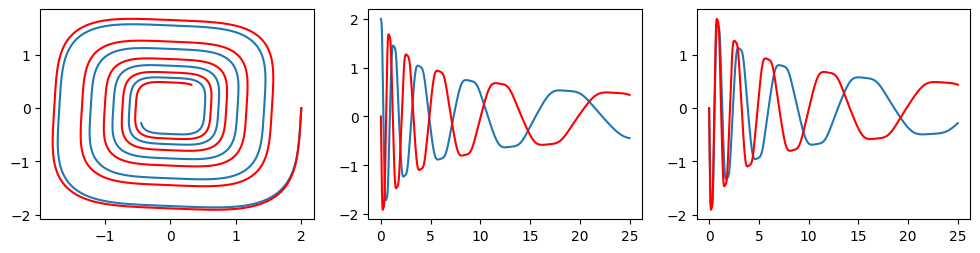

In [316]:

x_hat = np.array([2,0.])
x_hats = [x_hat]
for x in tqdm(X[:-1]):
    x_hat = x_hat + dt*np.concatenate([f0(x_hat), f1(x_hat)]).dot(coeffs)
    x_hats.append(x_hat)
x_hats = np.array(x_hats)

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1_cubic[0,:], xx1_cubic[1,:])
ax.plot(x_hats[:,0], x_hats[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1_cubic[0,:])
ax.plot(times, x_hats[:,1], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1_cubic[1,:])
ax.plot(times, x_hats[:,1], color="red")


array([[ 2.        ,  1.99601083,  1.99202782, ..., -0.44302946,
        -0.44320992, -0.44338823],
       [ 0.        , -0.0797607 , -0.15904433, ..., -0.28231653,
        -0.28143525, -0.28055301]])